In [1]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

sns.set_theme()
sns.set_context("paper")

In [2]:
fig_dir = Path.home() / "dev/data/exp/follow/figures"
fig_dir.mkdir(parents=True, exist_ok=True)

RHCR_dir = Path.home() / "dev/data/exp/RHCR"

# PBS
exp_runs = glob.glob("2024-12-11*/", root_dir=RHCR_dir)
# LaCAM
# exp_runs += glob.glob("2024-12-12*/", root_dir=RHCR_dir)

data_dirs = [RHCR_dir / run for run in exp_runs]

In [3]:
def read_yaml(file_path):
    with open(file_path, mode="r") as file:
        data = yaml.safe_load(file)
    return data


configs = [read_yaml(data_dir / "config.yaml") for data_dir in data_dirs]
for i in range(1, len(configs)):
    assert configs[i]["git_hash"] == configs[i - 1]["git_hash"]

df = pd.concat(
    [pd.read_csv(data_dir / "result.csv") for data_dir in data_dirs], ignore_index=True
)

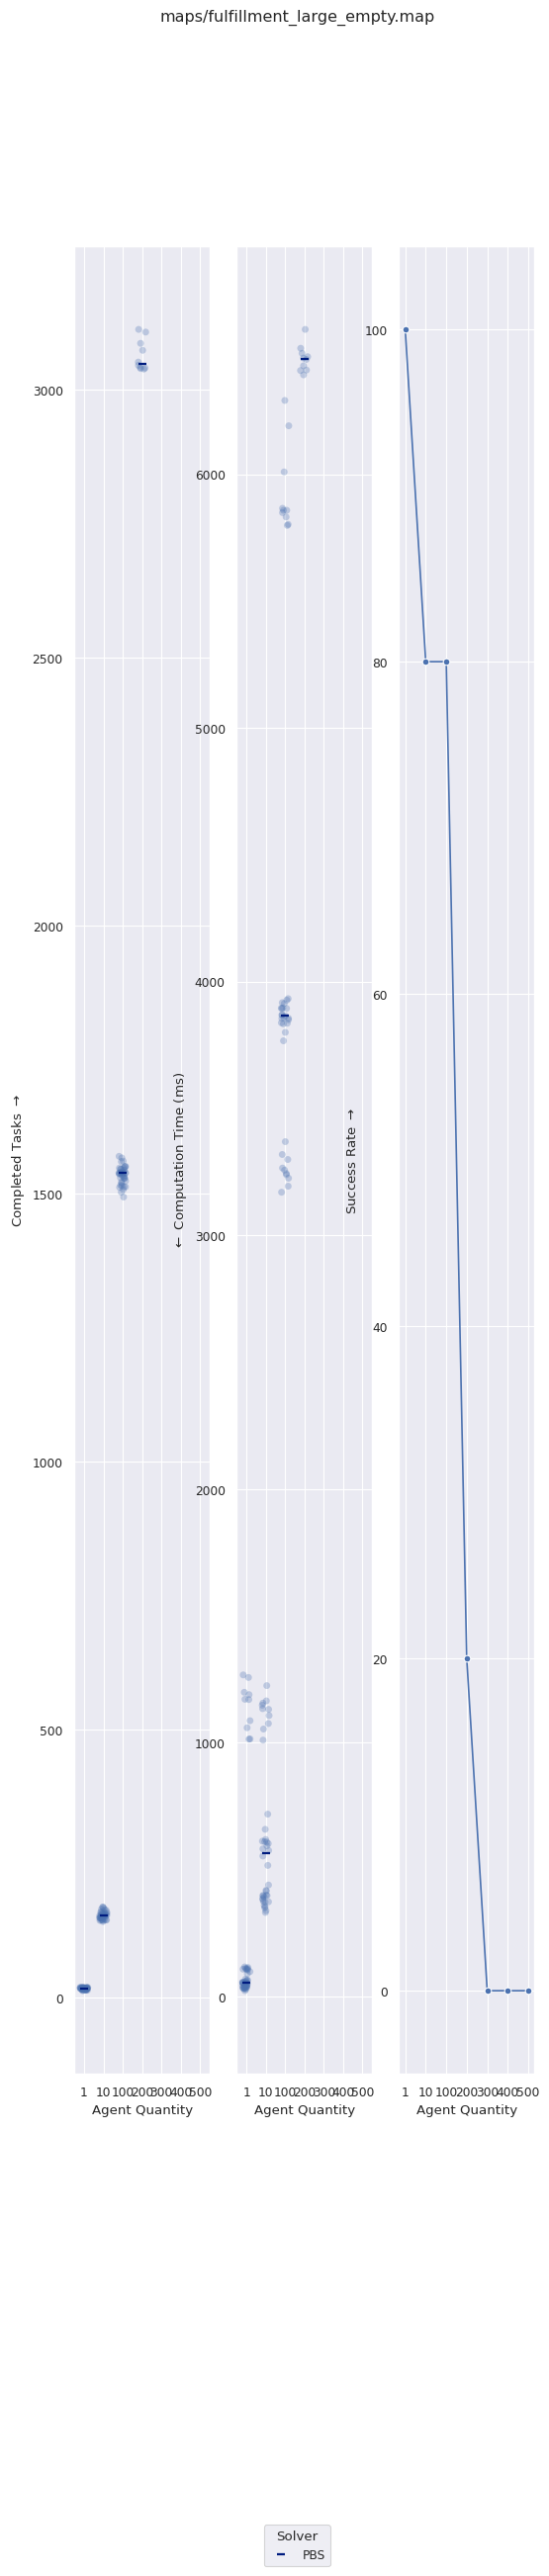

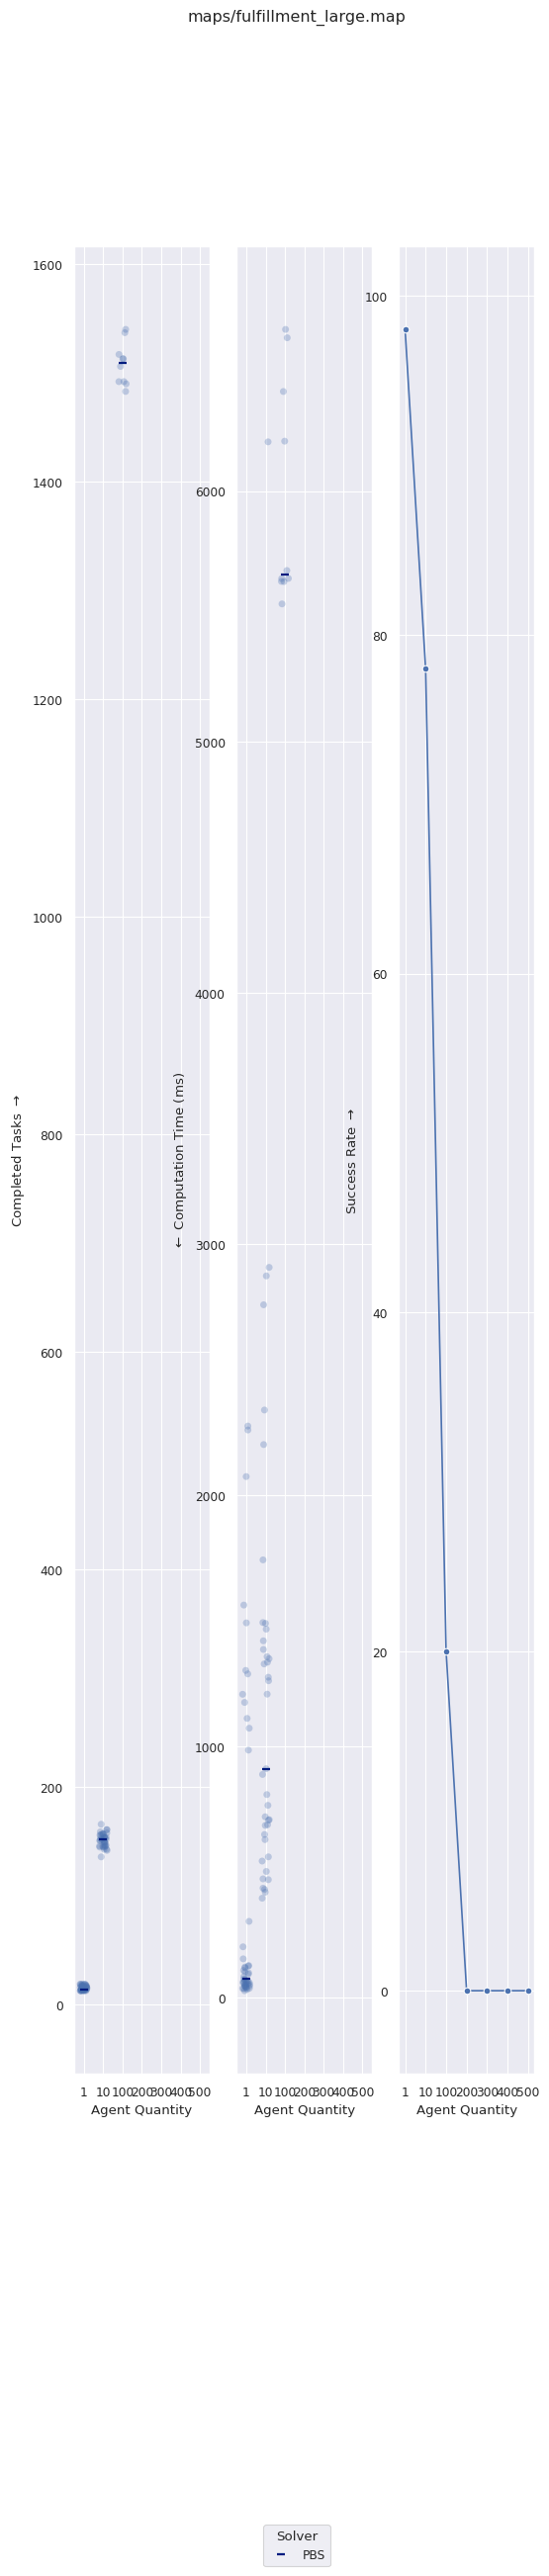

In [14]:
maps = df["map"].unique()
x_vars = [
    "agentNum",
    # "simulation_window",
]
xlabels = {
    "agentNum": "Agent Quantity",
    "simulation_window": "Simulation Window Size (steps)"
}
for map in maps:
    for x_var in x_vars:
        fig, axs = plt.subplots(1, 3)
        # fig.suptitle(f"Effect of {x_var} on Throughput, Runtime, and Success Rate on {map}")
        fig.suptitle(f"{map}")
        fig.set_size_inches(6, 24)
        fig_legend = None

        y_vars = [
            "completed_tasks",
            "runtime_s",
            "success_rate",
        ]
        ylabels = {
            "completed_tasks": "Completed Tasks $\\rightarrow$",
            "runtime_s": "$\\leftarrow$ Computation Time (ms)",
            "success_rate": "Success Rate $\\rightarrow$",
        }
        for i, y_var in enumerate(y_vars):
            ax = axs[i]

            filtered: pd.DataFrame = df[df["map"] == map]

            if y_var == "success_rate":
                success_rate_df = (
                    filtered.groupby(["solver", x_var])
                    .apply(
                        lambda group: group["completed_tasks"].notna().sum()
                        / len(group)
                        * 100,
                        include_groups=False,
                    )
                    .reset_index(name="success_rate")
                )

                success_rate_df[x_var] = success_rate_df[x_var].astype(str)

                melted = success_rate_df.melt(
                    id_vars=["solver", x_var], var_name="measurement", value_name="value"
                )
                melted["solver"] = pd.Categorical(
                    melted["solver"], melted["solver"].unique().sort()
                )

                ax = sns.lineplot(
                    data=melted,
                    x=x_var,
                    y="value",
                    hue="solver",
                    marker="o",
                    ax=ax,
                    legend=True,
                    zorder=1,
                )
            else:
                melted = filtered.melt(
                    id_vars=["solver", x_var], var_name="measurement", value_vars=[y_var]
                )
                melted["solver"] = pd.Categorical(
                    melted["solver"], melted["solver"].unique().sort()
                )

                # Linearize x-axis
                # new_rows = []
                # for n in range(min(df[x_var].unique()), max(df[x_var].unique()) + 1):
                #     if n not in melted[x_var].values:
                #         for solver in melted["solver"].unique():
                #             new_rows.append(
                #                 {
                #                             "solver": solver,
                #                             x_var: n,
                #                             "measurement": y_var,
                #                             "value": float("nan"),
                #                         }
                #             )
                # new_df = pd.DataFrame(new_rows)
                # melted = pd.concat([melted, new_df], ignore_index=True)

                ax = sns.stripplot(
                    data=melted,
                    x=x_var,
                    y="value",
                    hue="solver",
                    dodge=True,
                    alpha=0.3,
                    jitter=0.2,
                    ax=ax,
                    legend=False,
                    zorder=1,
                )

                ax = sns.pointplot(
                    data=melted,
                    x=x_var,
                    y="value",
                    hue="solver",
                    dodge=0.8 - 0.8 / len(melted["solver"].unique()),
                    palette="dark",
                    errorbar=None,
                    markers="_",
                    linestyle="none",
                    ax=ax,
                    legend=True,
                    estimator="median",
                )

                # Fix labels when x-axis is linearized
                # ax.set_xticks(range(0, melted[x_var].max() + 1))
                # ax.set_xticklabels([x if x in melted[x_var].unique() else '' for x in range(0, melted[x_var].max() + 1)])

            ax.set_xlabel(xlabels[x_var])
            ax.set_ylabel(ylabels[y_var])
            ax.grid(True)

            if (legend := ax.get_legend()) is not None:
                legend.remove()
            if fig_legend is None:
                legend_handles, legend_labels = ax.get_legend_handles_labels()
                fig_legend = fig.legend(
                    legend_handles,
                    legend_labels,
                    loc="lower center",
                    bbox_to_anchor=(0.5, -0.1),
                    ncol=len(melted["solver"].unique()),
                    frameon=True,
                    title="Solver",
                )
